In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [17]:
DATASET = r"C:\Users\mzlwm\OneDrive\Desktop\MEDGAN\dataset"
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [32, 32, 32, 16, 16, 16] #you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
image_size              = 128
CHANNELS_IMG            = 3
Z_DIM                   = 256  # should be 512 in original paper
IN_CHANNELS             = 256  # should be 512 in original paper
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)
#PROGRESSIVE_EPOCHS = [5] * len(BATCH_SIZES)  # Set 5 epochs for testing

In [4]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

In [5]:
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset

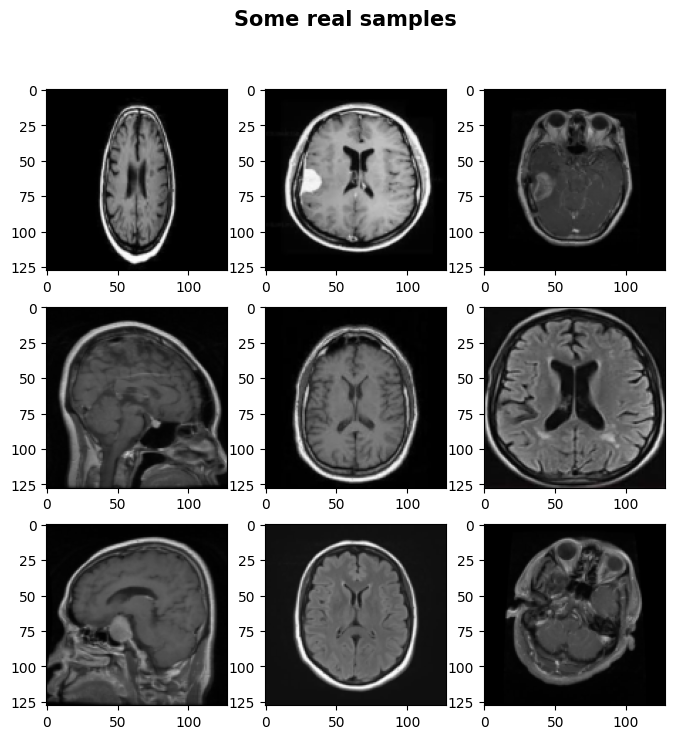

In [6]:
def check_loader():
    loader,_ = get_loader(128)
    cloth ,_ = next(iter(loader))
    _, ax    = plt.subplots(3,3, figsize=(8,8))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ind += 1
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
check_loader()

In [7]:
class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
    ):
        super(WSConv2d, self).__init__()
        self.conv      = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale     = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias      = self.conv.bias #Copy the bias of the current column layer
        self.conv.bias = None      #Remove the bias

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [8]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1  = WSConv2d(in_channels, out_channels)
        self.conv2  = WSConv2d(out_channels, out_channels)
        self.leaky  = nn.LeakyReLU(0.2)
        self.pn     = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [12]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [13]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [14]:
torch.backends.cudnn.benchmarks = True

In [15]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )


    return alpha


In [18]:
# initialize gen and disc, note: discriminator we called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(
    IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

# initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)


gen.train()
critic.train()

step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS:
    alpha = 1e-5  # start with very low alpha, you can start with alpha=0
    loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
        )
    generate_examples(gen, step, n=100)


    step += 1  # progress to the next img size

Current image size: 4
Epoch [1/30]


100%|██████████| 220/220 [00:17<00:00, 12.54it/s, gp=0.0222, loss_critic=-0.865]


Epoch [2/30]


100%|██████████| 220/220 [00:20<00:00, 10.81it/s, gp=0.0162, loss_critic=-0.474] 


Epoch [3/30]


100%|██████████| 220/220 [00:21<00:00, 10.28it/s, gp=0.00761, loss_critic=-0.349]


Epoch [4/30]


100%|██████████| 220/220 [00:17<00:00, 12.33it/s, gp=0.00673, loss_critic=-0.262]


Epoch [5/30]


100%|██████████| 220/220 [00:23<00:00,  9.53it/s, gp=0.00937, loss_critic=-0.149] 


Epoch [6/30]


100%|██████████| 220/220 [00:17<00:00, 12.58it/s, gp=0.00668, loss_critic=-0.0639] 


Epoch [7/30]


100%|██████████| 220/220 [00:16<00:00, 12.95it/s, gp=0.0125, loss_critic=0.125]    


Epoch [8/30]


100%|██████████| 220/220 [00:20<00:00, 10.94it/s, gp=0.00394, loss_critic=-0.0668] 


Epoch [9/30]


100%|██████████| 220/220 [00:16<00:00, 13.57it/s, gp=0.00793, loss_critic=-0.0692]


Epoch [10/30]


100%|██████████| 220/220 [00:18<00:00, 11.98it/s, gp=0.00871, loss_critic=0.0103]  


Epoch [11/30]


100%|██████████| 220/220 [00:17<00:00, 12.44it/s, gp=0.00282, loss_critic=0.00804] 


Epoch [12/30]


100%|██████████| 220/220 [00:18<00:00, 11.70it/s, gp=0.0106, loss_critic=-0.0734]  


Epoch [13/30]


100%|██████████| 220/220 [00:18<00:00, 12.14it/s, gp=0.011, loss_critic=0.054]     


Epoch [14/30]


100%|██████████| 220/220 [00:19<00:00, 11.39it/s, gp=0.0106, loss_critic=0.121]    


Epoch [15/30]


100%|██████████| 220/220 [00:19<00:00, 11.34it/s, gp=0.00731, loss_critic=-0.0778] 


Epoch [16/30]


100%|██████████| 220/220 [00:18<00:00, 12.18it/s, gp=0.00357, loss_critic=-0.137]  


Epoch [17/30]


100%|██████████| 220/220 [00:18<00:00, 12.08it/s, gp=0.0174, loss_critic=0.00551]  


Epoch [18/30]


100%|██████████| 220/220 [00:19<00:00, 11.30it/s, gp=0.0186, loss_critic=0.0269]    


Epoch [19/30]


100%|██████████| 220/220 [00:17<00:00, 12.23it/s, gp=0.00165, loss_critic=-0.0465]


Epoch [20/30]


100%|██████████| 220/220 [00:18<00:00, 11.76it/s, gp=0.0041, loss_critic=0.0958]   


Epoch [21/30]


100%|██████████| 220/220 [00:18<00:00, 11.76it/s, gp=0.00152, loss_critic=-0.134]  


Epoch [22/30]


100%|██████████| 220/220 [00:21<00:00, 10.24it/s, gp=0.00453, loss_critic=-0.113]   


Epoch [23/30]


100%|██████████| 220/220 [00:17<00:00, 12.52it/s, gp=0.00537, loss_critic=-0.033]  


Epoch [24/30]


100%|██████████| 220/220 [00:16<00:00, 13.13it/s, gp=0.0053, loss_critic=-0.0253]  


Epoch [25/30]


100%|██████████| 220/220 [00:17<00:00, 12.71it/s, gp=0.00642, loss_critic=-0.122]  


Epoch [26/30]


100%|██████████| 220/220 [00:17<00:00, 12.65it/s, gp=0.00628, loss_critic=-0.0547]  


Epoch [27/30]


100%|██████████| 220/220 [00:17<00:00, 12.43it/s, gp=0.00108, loss_critic=-0.15]   


Epoch [28/30]


100%|██████████| 220/220 [00:20<00:00, 10.68it/s, gp=0.00142, loss_critic=-0.0664]  


Epoch [29/30]


100%|██████████| 220/220 [00:19<00:00, 11.29it/s, gp=0.00284, loss_critic=-0.0247] 


Epoch [30/30]


100%|██████████| 220/220 [00:17<00:00, 12.64it/s, gp=0.000675, loss_critic=-0.056] 


Current image size: 8
Epoch [1/30]


100%|██████████| 220/220 [00:20<00:00, 10.84it/s, gp=0.0055, loss_critic=-0.279]   


Epoch [2/30]


100%|██████████| 220/220 [00:18<00:00, 12.09it/s, gp=0.00091, loss_critic=-0.284]  


Epoch [3/30]


100%|██████████| 220/220 [00:20<00:00, 10.63it/s, gp=0.00486, loss_critic=-0.226]   


Epoch [4/30]


100%|██████████| 220/220 [00:20<00:00, 10.73it/s, gp=0.00288, loss_critic=-0.133]  


Epoch [5/30]


100%|██████████| 220/220 [00:19<00:00, 11.03it/s, gp=0.0026, loss_critic=-0.17]   


Epoch [6/30]


100%|██████████| 220/220 [00:19<00:00, 11.47it/s, gp=0.00938, loss_critic=0.323]   


Epoch [7/30]


100%|██████████| 220/220 [00:21<00:00, 10.44it/s, gp=0.00339, loss_critic=-0.139] 


Epoch [8/30]


100%|██████████| 220/220 [00:20<00:00, 10.67it/s, gp=0.00542, loss_critic=-0.144]  


Epoch [9/30]


100%|██████████| 220/220 [00:19<00:00, 11.26it/s, gp=0.00475, loss_critic=-0.306]  


Epoch [10/30]


100%|██████████| 220/220 [00:19<00:00, 11.12it/s, gp=0.00767, loss_critic=-0.122] 


Epoch [11/30]


100%|██████████| 220/220 [00:21<00:00, 10.20it/s, gp=0.00889, loss_critic=-0.156]  


Epoch [12/30]


100%|██████████| 220/220 [00:18<00:00, 11.65it/s, gp=0.00169, loss_critic=-0.236]   


Epoch [13/30]


100%|██████████| 220/220 [00:19<00:00, 11.57it/s, gp=0.00787, loss_critic=0.277]   


Epoch [14/30]


100%|██████████| 220/220 [00:19<00:00, 11.45it/s, gp=0.00306, loss_critic=0.214]   


Epoch [15/30]


100%|██████████| 220/220 [00:19<00:00, 11.41it/s, gp=0.0138, loss_critic=-0.25]    


Epoch [16/30]


100%|██████████| 220/220 [00:19<00:00, 11.46it/s, gp=0.0118, loss_critic=-0.0125]  


Epoch [17/30]


100%|██████████| 220/220 [00:18<00:00, 11.59it/s, gp=0.00176, loss_critic=-0.204]  


Epoch [18/30]


100%|██████████| 220/220 [00:19<00:00, 11.26it/s, gp=0.00349, loss_critic=-0.118]  


Epoch [19/30]


100%|██████████| 220/220 [00:18<00:00, 11.72it/s, gp=0.00804, loss_critic=-0.0909] 


Epoch [20/30]


100%|██████████| 220/220 [00:20<00:00, 10.76it/s, gp=0.0173, loss_critic=0.0996]   


Epoch [21/30]


100%|██████████| 220/220 [00:18<00:00, 11.66it/s, gp=0.00303, loss_critic=-0.109]   


Epoch [22/30]


100%|██████████| 220/220 [00:19<00:00, 11.42it/s, gp=0.0134, loss_critic=-0.00111] 


Epoch [23/30]


100%|██████████| 220/220 [00:19<00:00, 11.34it/s, gp=0.00264, loss_critic=-0.127]  


Epoch [24/30]


100%|██████████| 220/220 [00:25<00:00,  8.64it/s, gp=0.0016, loss_critic=0.0401]   


Epoch [25/30]


100%|██████████| 220/220 [00:24<00:00,  8.90it/s, gp=0.00349, loss_critic=-0.13]   


Epoch [26/30]


100%|██████████| 220/220 [00:19<00:00, 11.20it/s, gp=0.00136, loss_critic=-0.233]  


Epoch [27/30]


100%|██████████| 220/220 [00:19<00:00, 11.46it/s, gp=0.00507, loss_critic=0.00277]  


Epoch [28/30]


100%|██████████| 220/220 [00:21<00:00, 10.36it/s, gp=0.000968, loss_critic=-0.0486]


Epoch [29/30]


100%|██████████| 220/220 [00:20<00:00, 10.98it/s, gp=0.00602, loss_critic=-0.0884] 


Epoch [30/30]


100%|██████████| 220/220 [00:20<00:00, 10.62it/s, gp=0.00382, loss_critic=-0.06]   


Current image size: 16
Epoch [1/30]


100%|██████████| 220/220 [00:28<00:00,  7.76it/s, gp=0.0184, loss_critic=0.0613]  


Epoch [2/30]


100%|██████████| 220/220 [00:28<00:00,  7.72it/s, gp=0.0042, loss_critic=-0.987]  


Epoch [3/30]


100%|██████████| 220/220 [00:27<00:00,  7.90it/s, gp=0.00499, loss_critic=-0.91] 


Epoch [4/30]


100%|██████████| 220/220 [00:27<00:00,  7.93it/s, gp=0.00488, loss_critic=-0.801]


Epoch [5/30]


100%|██████████| 220/220 [00:28<00:00,  7.79it/s, gp=0.00886, loss_critic=-1.15] 


Epoch [6/30]


100%|██████████| 220/220 [00:28<00:00,  7.78it/s, gp=0.00766, loss_critic=-0.578] 


Epoch [7/30]


100%|██████████| 220/220 [00:28<00:00,  7.82it/s, gp=0.008, loss_critic=-0.417]  


Epoch [8/30]


100%|██████████| 220/220 [00:29<00:00,  7.58it/s, gp=0.0144, loss_critic=-1.1]    


Epoch [9/30]


100%|██████████| 220/220 [00:29<00:00,  7.43it/s, gp=0.00386, loss_critic=-0.931]


Epoch [10/30]


100%|██████████| 220/220 [00:29<00:00,  7.44it/s, gp=0.0132, loss_critic=-0.774]  


Epoch [11/30]


100%|██████████| 220/220 [00:28<00:00,  7.78it/s, gp=0.00239, loss_critic=-0.958]


Epoch [12/30]


100%|██████████| 220/220 [00:28<00:00,  7.61it/s, gp=0.00125, loss_critic=-0.606]  


Epoch [13/30]


100%|██████████| 220/220 [00:30<00:00,  7.22it/s, gp=0.00784, loss_critic=-0.687] 


Epoch [14/30]


100%|██████████| 220/220 [00:28<00:00,  7.72it/s, gp=0.00534, loss_critic=-1.02] 


Epoch [15/30]


100%|██████████| 220/220 [00:28<00:00,  7.70it/s, gp=0.00195, loss_critic=-0.64] 


Epoch [16/30]


100%|██████████| 220/220 [00:31<00:00,  7.00it/s, gp=0.00268, loss_critic=-0.862] 


Epoch [17/30]


100%|██████████| 220/220 [00:30<00:00,  7.16it/s, gp=0.00534, loss_critic=-0.427] 


Epoch [18/30]


100%|██████████| 220/220 [00:28<00:00,  7.75it/s, gp=0.00418, loss_critic=-0.572] 


Epoch [19/30]


100%|██████████| 220/220 [00:28<00:00,  7.66it/s, gp=0.00234, loss_critic=-0.738]  


Epoch [20/30]


100%|██████████| 220/220 [00:28<00:00,  7.66it/s, gp=0.00659, loss_critic=-0.489]  


Epoch [21/30]


100%|██████████| 220/220 [00:30<00:00,  7.24it/s, gp=0.00477, loss_critic=-0.558] 


Epoch [22/30]


100%|██████████| 220/220 [00:30<00:00,  7.19it/s, gp=0.00366, loss_critic=-0.26]  


Epoch [23/30]


100%|██████████| 220/220 [00:29<00:00,  7.44it/s, gp=0.00343, loss_critic=-0.648] 


Epoch [24/30]


100%|██████████| 220/220 [00:28<00:00,  7.59it/s, gp=0.00395, loss_critic=-0.605] 


Epoch [25/30]


100%|██████████| 220/220 [00:29<00:00,  7.51it/s, gp=0.00216, loss_critic=-0.277]  


Epoch [26/30]


100%|██████████| 220/220 [00:29<00:00,  7.51it/s, gp=0.00397, loss_critic=-0.384]  


Epoch [27/30]


100%|██████████| 220/220 [00:29<00:00,  7.51it/s, gp=0.00341, loss_critic=0.118]   


Epoch [28/30]


100%|██████████| 220/220 [00:29<00:00,  7.38it/s, gp=0.00347, loss_critic=-0.316] 


Epoch [29/30]


100%|██████████| 220/220 [00:29<00:00,  7.54it/s, gp=0.00394, loss_critic=-0.242] 


Epoch [30/30]


100%|██████████| 220/220 [00:29<00:00,  7.53it/s, gp=0.00437, loss_critic=-0.14]   


Current image size: 32
Epoch [1/30]


100%|██████████| 439/439 [01:20<00:00,  5.45it/s, gp=0.101, loss_critic=-1.44]    


Epoch [2/30]


100%|██████████| 439/439 [01:20<00:00,  5.45it/s, gp=0.0286, loss_critic=-1.3]   


Epoch [3/30]


100%|██████████| 439/439 [01:19<00:00,  5.49it/s, gp=0.00696, loss_critic=-1.81] 


Epoch [4/30]


100%|██████████| 439/439 [01:21<00:00,  5.41it/s, gp=0.00216, loss_critic=-1.63]  


Epoch [5/30]


100%|██████████| 439/439 [01:20<00:00,  5.47it/s, gp=0.0132, loss_critic=-0.811]   


Epoch [6/30]


100%|██████████| 439/439 [01:20<00:00,  5.48it/s, gp=0.00733, loss_critic=-1.31]   


Epoch [7/30]


100%|██████████| 439/439 [01:20<00:00,  5.47it/s, gp=0.00621, loss_critic=-1.03]  


Epoch [8/30]


100%|██████████| 439/439 [01:21<00:00,  5.41it/s, gp=0.0098, loss_critic=-1.31]   


Epoch [9/30]


100%|██████████| 439/439 [01:20<00:00,  5.44it/s, gp=0.0106, loss_critic=-1.39]  


Epoch [10/30]


100%|██████████| 439/439 [01:19<00:00,  5.50it/s, gp=0.00693, loss_critic=-1.05] 


Epoch [11/30]


100%|██████████| 439/439 [01:20<00:00,  5.48it/s, gp=0.000914, loss_critic=-1.08] 


Epoch [12/30]


100%|██████████| 439/439 [01:20<00:00,  5.46it/s, gp=0.00775, loss_critic=-1.42]  


Epoch [13/30]


100%|██████████| 439/439 [01:19<00:00,  5.53it/s, gp=0.00464, loss_critic=-0.961] 


Epoch [14/30]


100%|██████████| 439/439 [01:20<00:00,  5.47it/s, gp=0.00446, loss_critic=-1.36]  


Epoch [15/30]


100%|██████████| 439/439 [01:20<00:00,  5.47it/s, gp=0.00831, loss_critic=-1.06]  


Epoch [16/30]


100%|██████████| 439/439 [01:20<00:00,  5.44it/s, gp=0.00677, loss_critic=-0.699] 


Epoch [17/30]


100%|██████████| 439/439 [01:20<00:00,  5.45it/s, gp=0.00911, loss_critic=-1.11]  


Epoch [18/30]


100%|██████████| 439/439 [01:19<00:00,  5.49it/s, gp=0.027, loss_critic=-0.242]    


Epoch [19/30]


100%|██████████| 439/439 [01:20<00:00,  5.47it/s, gp=0.00799, loss_critic=-1.19]  


Epoch [20/30]


100%|██████████| 439/439 [01:19<00:00,  5.51it/s, gp=0.00158, loss_critic=-0.837] 


Epoch [21/30]


100%|██████████| 439/439 [01:19<00:00,  5.49it/s, gp=0.00524, loss_critic=-0.722] 


Epoch [22/30]


100%|██████████| 439/439 [01:20<00:00,  5.47it/s, gp=0.00523, loss_critic=-1.02]    


Epoch [23/30]


100%|██████████| 439/439 [01:21<00:00,  5.37it/s, gp=0.00394, loss_critic=-0.342] 


Epoch [24/30]


100%|██████████| 439/439 [01:21<00:00,  5.37it/s, gp=0.00443, loss_critic=-0.712]  


Epoch [25/30]


100%|██████████| 439/439 [01:19<00:00,  5.55it/s, gp=0.00522, loss_critic=-1.1]   


Epoch [26/30]


100%|██████████| 439/439 [01:19<00:00,  5.50it/s, gp=0.00541, loss_critic=-0.566]  


Epoch [27/30]


100%|██████████| 439/439 [01:20<00:00,  5.47it/s, gp=0.0107, loss_critic=-0.873]   


Epoch [28/30]


100%|██████████| 439/439 [01:21<00:00,  5.37it/s, gp=0.00509, loss_critic=-1]      


Epoch [29/30]


100%|██████████| 439/439 [01:20<00:00,  5.42it/s, gp=0.00149, loss_critic=-0.417] 


Epoch [30/30]


100%|██████████| 439/439 [01:20<00:00,  5.44it/s, gp=0.00331, loss_critic=-0.981] 


Current image size: 64
Epoch [1/30]


100%|██████████| 439/439 [03:34<00:00,  2.05it/s, gp=0.11, loss_critic=-5.47]     


Epoch [2/30]


100%|██████████| 439/439 [03:33<00:00,  2.06it/s, gp=0.0235, loss_critic=-5]     


Epoch [3/30]


100%|██████████| 439/439 [03:36<00:00,  2.02it/s, gp=0.0195, loss_critic=-1.17]  


Epoch [4/30]


100%|██████████| 439/439 [03:39<00:00,  2.00it/s, gp=0.0124, loss_critic=-2.67]  


Epoch [5/30]


100%|██████████| 439/439 [03:38<00:00,  2.01it/s, gp=0.0195, loss_critic=-1.97]  


Epoch [6/30]


100%|██████████| 439/439 [03:35<00:00,  2.03it/s, gp=0.0152, loss_critic=-3.01] 


Epoch [7/30]


100%|██████████| 439/439 [03:37<00:00,  2.02it/s, gp=0.00942, loss_critic=-1.53] 


Epoch [8/30]


100%|██████████| 439/439 [03:33<00:00,  2.06it/s, gp=0.0189, loss_critic=-3.35]  


Epoch [9/30]


100%|██████████| 439/439 [03:34<00:00,  2.05it/s, gp=0.0248, loss_critic=-2.25]   


Epoch [10/30]


100%|██████████| 439/439 [03:35<00:00,  2.04it/s, gp=0.0134, loss_critic=-2.72]   


Epoch [11/30]


100%|██████████| 439/439 [03:35<00:00,  2.04it/s, gp=0.0149, loss_critic=-2.19]  


Epoch [12/30]


100%|██████████| 439/439 [03:34<00:00,  2.05it/s, gp=0.0259, loss_critic=-2.2]   


Epoch [13/30]


100%|██████████| 439/439 [03:33<00:00,  2.06it/s, gp=0.00891, loss_critic=-2.76] 


Epoch [14/30]


100%|██████████| 439/439 [03:33<00:00,  2.06it/s, gp=0.00982, loss_critic=-3.06] 


Epoch [15/30]


100%|██████████| 439/439 [03:37<00:00,  2.02it/s, gp=0.00669, loss_critic=-2.35] 


Epoch [16/30]


100%|██████████| 439/439 [03:47<00:00,  1.93it/s, gp=0.0227, loss_critic=-1.91]  


Epoch [17/30]


100%|██████████| 439/439 [03:37<00:00,  2.02it/s, gp=0.0287, loss_critic=-0.323] 


Epoch [18/30]


100%|██████████| 439/439 [03:37<00:00,  2.02it/s, gp=0.0105, loss_critic=-2.3]   


Epoch [19/30]


100%|██████████| 439/439 [03:37<00:00,  2.02it/s, gp=0.0129, loss_critic=-2.23]   


Epoch [20/30]


100%|██████████| 439/439 [03:37<00:00,  2.02it/s, gp=0.017, loss_critic=-2.96]    


Epoch [21/30]


100%|██████████| 439/439 [03:38<00:00,  2.01it/s, gp=0.00888, loss_critic=-1.75] 


Epoch [22/30]


100%|██████████| 439/439 [03:39<00:00,  2.00it/s, gp=0.0121, loss_critic=-0.491]  


Epoch [23/30]


100%|██████████| 439/439 [03:38<00:00,  2.01it/s, gp=0.0107, loss_critic=-2.37]   


Epoch [24/30]


100%|██████████| 439/439 [03:33<00:00,  2.06it/s, gp=0.00921, loss_critic=-1.09] 


Epoch [25/30]


100%|██████████| 439/439 [03:35<00:00,  2.04it/s, gp=0.00245, loss_critic=-2.32]  


Epoch [26/30]


100%|██████████| 439/439 [03:38<00:00,  2.01it/s, gp=0.0168, loss_critic=-0.977] 


Epoch [27/30]


100%|██████████| 439/439 [03:37<00:00,  2.02it/s, gp=0.0104, loss_critic=-1.32]  


Epoch [28/30]


100%|██████████| 439/439 [03:45<00:00,  1.95it/s, gp=0.016, loss_critic=-1.83]    


Epoch [29/30]


100%|██████████| 439/439 [03:40<00:00,  1.99it/s, gp=0.00329, loss_critic=-2.13] 


Epoch [30/30]


100%|██████████| 439/439 [03:41<00:00,  1.98it/s, gp=0.015, loss_critic=-2.32]    


Current image size: 128
Epoch [1/30]


100%|██████████| 439/439 [09:23<00:00,  1.28s/it, gp=0.0491, loss_critic=-9.02]  


Epoch [2/30]


100%|██████████| 439/439 [09:24<00:00,  1.28s/it, gp=0.0366, loss_critic=-4.9] 


Epoch [3/30]


100%|██████████| 439/439 [09:24<00:00,  1.28s/it, gp=0.0702, loss_critic=-5.42]  


Epoch [4/30]


100%|██████████| 439/439 [09:24<00:00,  1.29s/it, gp=0.0644, loss_critic=-1.4]  


Epoch [5/30]


100%|██████████| 439/439 [09:32<00:00,  1.30s/it, gp=0.0568, loss_critic=-6.31] 


Epoch [6/30]


100%|██████████| 439/439 [09:24<00:00,  1.28s/it, gp=0.0558, loss_critic=-2.09] 


Epoch [7/30]


100%|██████████| 439/439 [09:41<00:00,  1.33s/it, gp=0.0477, loss_critic=-1.99]   


Epoch [8/30]


100%|██████████| 439/439 [09:25<00:00,  1.29s/it, gp=0.0503, loss_critic=-6.3]    


Epoch [9/30]


100%|██████████| 439/439 [09:14<00:00,  1.26s/it, gp=0.123, loss_critic=-6.96]  


Epoch [10/30]


100%|██████████| 439/439 [09:26<00:00,  1.29s/it, gp=0.0563, loss_critic=-4.59]  


Epoch [11/30]


100%|██████████| 439/439 [15:40<00:00,  2.14s/it, gp=0.122, loss_critic=-3.04]  


Epoch [12/30]


100%|██████████| 439/439 [17:34<00:00,  2.40s/it, gp=0.105, loss_critic=-5.46]  


Epoch [13/30]


100%|██████████| 439/439 [17:31<00:00,  2.39s/it, gp=0.0296, loss_critic=-1.9]  


Epoch [14/30]


100%|██████████| 439/439 [17:31<00:00,  2.40s/it, gp=0.133, loss_critic=-7.47]  


Epoch [15/30]


100%|██████████| 439/439 [17:36<00:00,  2.41s/it, gp=0.0396, loss_critic=-3.77] 


Epoch [16/30]


100%|██████████| 439/439 [17:36<00:00,  2.41s/it, gp=0.0401, loss_critic=-7.9]  


Epoch [17/30]


100%|██████████| 439/439 [17:49<00:00,  2.44s/it, gp=0.0647, loss_critic=-0.639]


Epoch [18/30]


100%|██████████| 439/439 [17:45<00:00,  2.43s/it, gp=0.0424, loss_critic=-5.89] 


Epoch [19/30]


100%|██████████| 439/439 [17:38<00:00,  2.41s/it, gp=0.0458, loss_critic=-7.43] 


Epoch [20/30]


100%|██████████| 439/439 [17:41<00:00,  2.42s/it, gp=0.0361, loss_critic=-4.96] 


Epoch [21/30]


100%|██████████| 439/439 [17:53<00:00,  2.45s/it, gp=0.0581, loss_critic=-2.17]  


Epoch [22/30]


100%|██████████| 439/439 [17:36<00:00,  2.41s/it, gp=0.0328, loss_critic=-0.414]


Epoch [23/30]


100%|██████████| 439/439 [17:32<00:00,  2.40s/it, gp=0.0431, loss_critic=-5.54]   


Epoch [24/30]


100%|██████████| 439/439 [17:33<00:00,  2.40s/it, gp=0.0754, loss_critic=-5.72] 


Epoch [25/30]


100%|██████████| 439/439 [17:30<00:00,  2.39s/it, gp=0.0568, loss_critic=-7.91] 


Epoch [26/30]


100%|██████████| 439/439 [17:33<00:00,  2.40s/it, gp=0.0608, loss_critic=-2.97]  


Epoch [27/30]


100%|██████████| 439/439 [17:43<00:00,  2.42s/it, gp=0.0399, loss_critic=-6.53]  


Epoch [28/30]


100%|██████████| 439/439 [17:44<00:00,  2.43s/it, gp=0.0353, loss_critic=-8.12] 


Epoch [29/30]


100%|██████████| 439/439 [17:38<00:00,  2.41s/it, gp=0.0266, loss_critic=-2.2]   


Epoch [30/30]


100%|██████████| 439/439 [17:34<00:00,  2.40s/it, gp=0.0654, loss_critic=-4.81] 


In [28]:
# prompt: save the madel as pht file and h5 and pkl 

import torch
import os

# Assuming 'gen' and 'critic' are your trained generator and critic models
# ... (Your existing code)

# Save the model as a .pth file
torch.save(gen.state_dict(), 'generator.pth')
torch.save(critic.state_dict(), 'critic.pth')


# Save the model as an .h5 file (requires h5py library)
!pip install h5py
import h5py

with h5py.File('generator.h5', 'w') as hf:
    for k, v in gen.state_dict().items():
        hf.create_dataset(k, data=v.cpu().numpy())

with h5py.File('critic.h5', 'w') as hf:
    for k, v in critic.state_dict().items():
        hf.create_dataset(k, data=v.cpu().numpy())


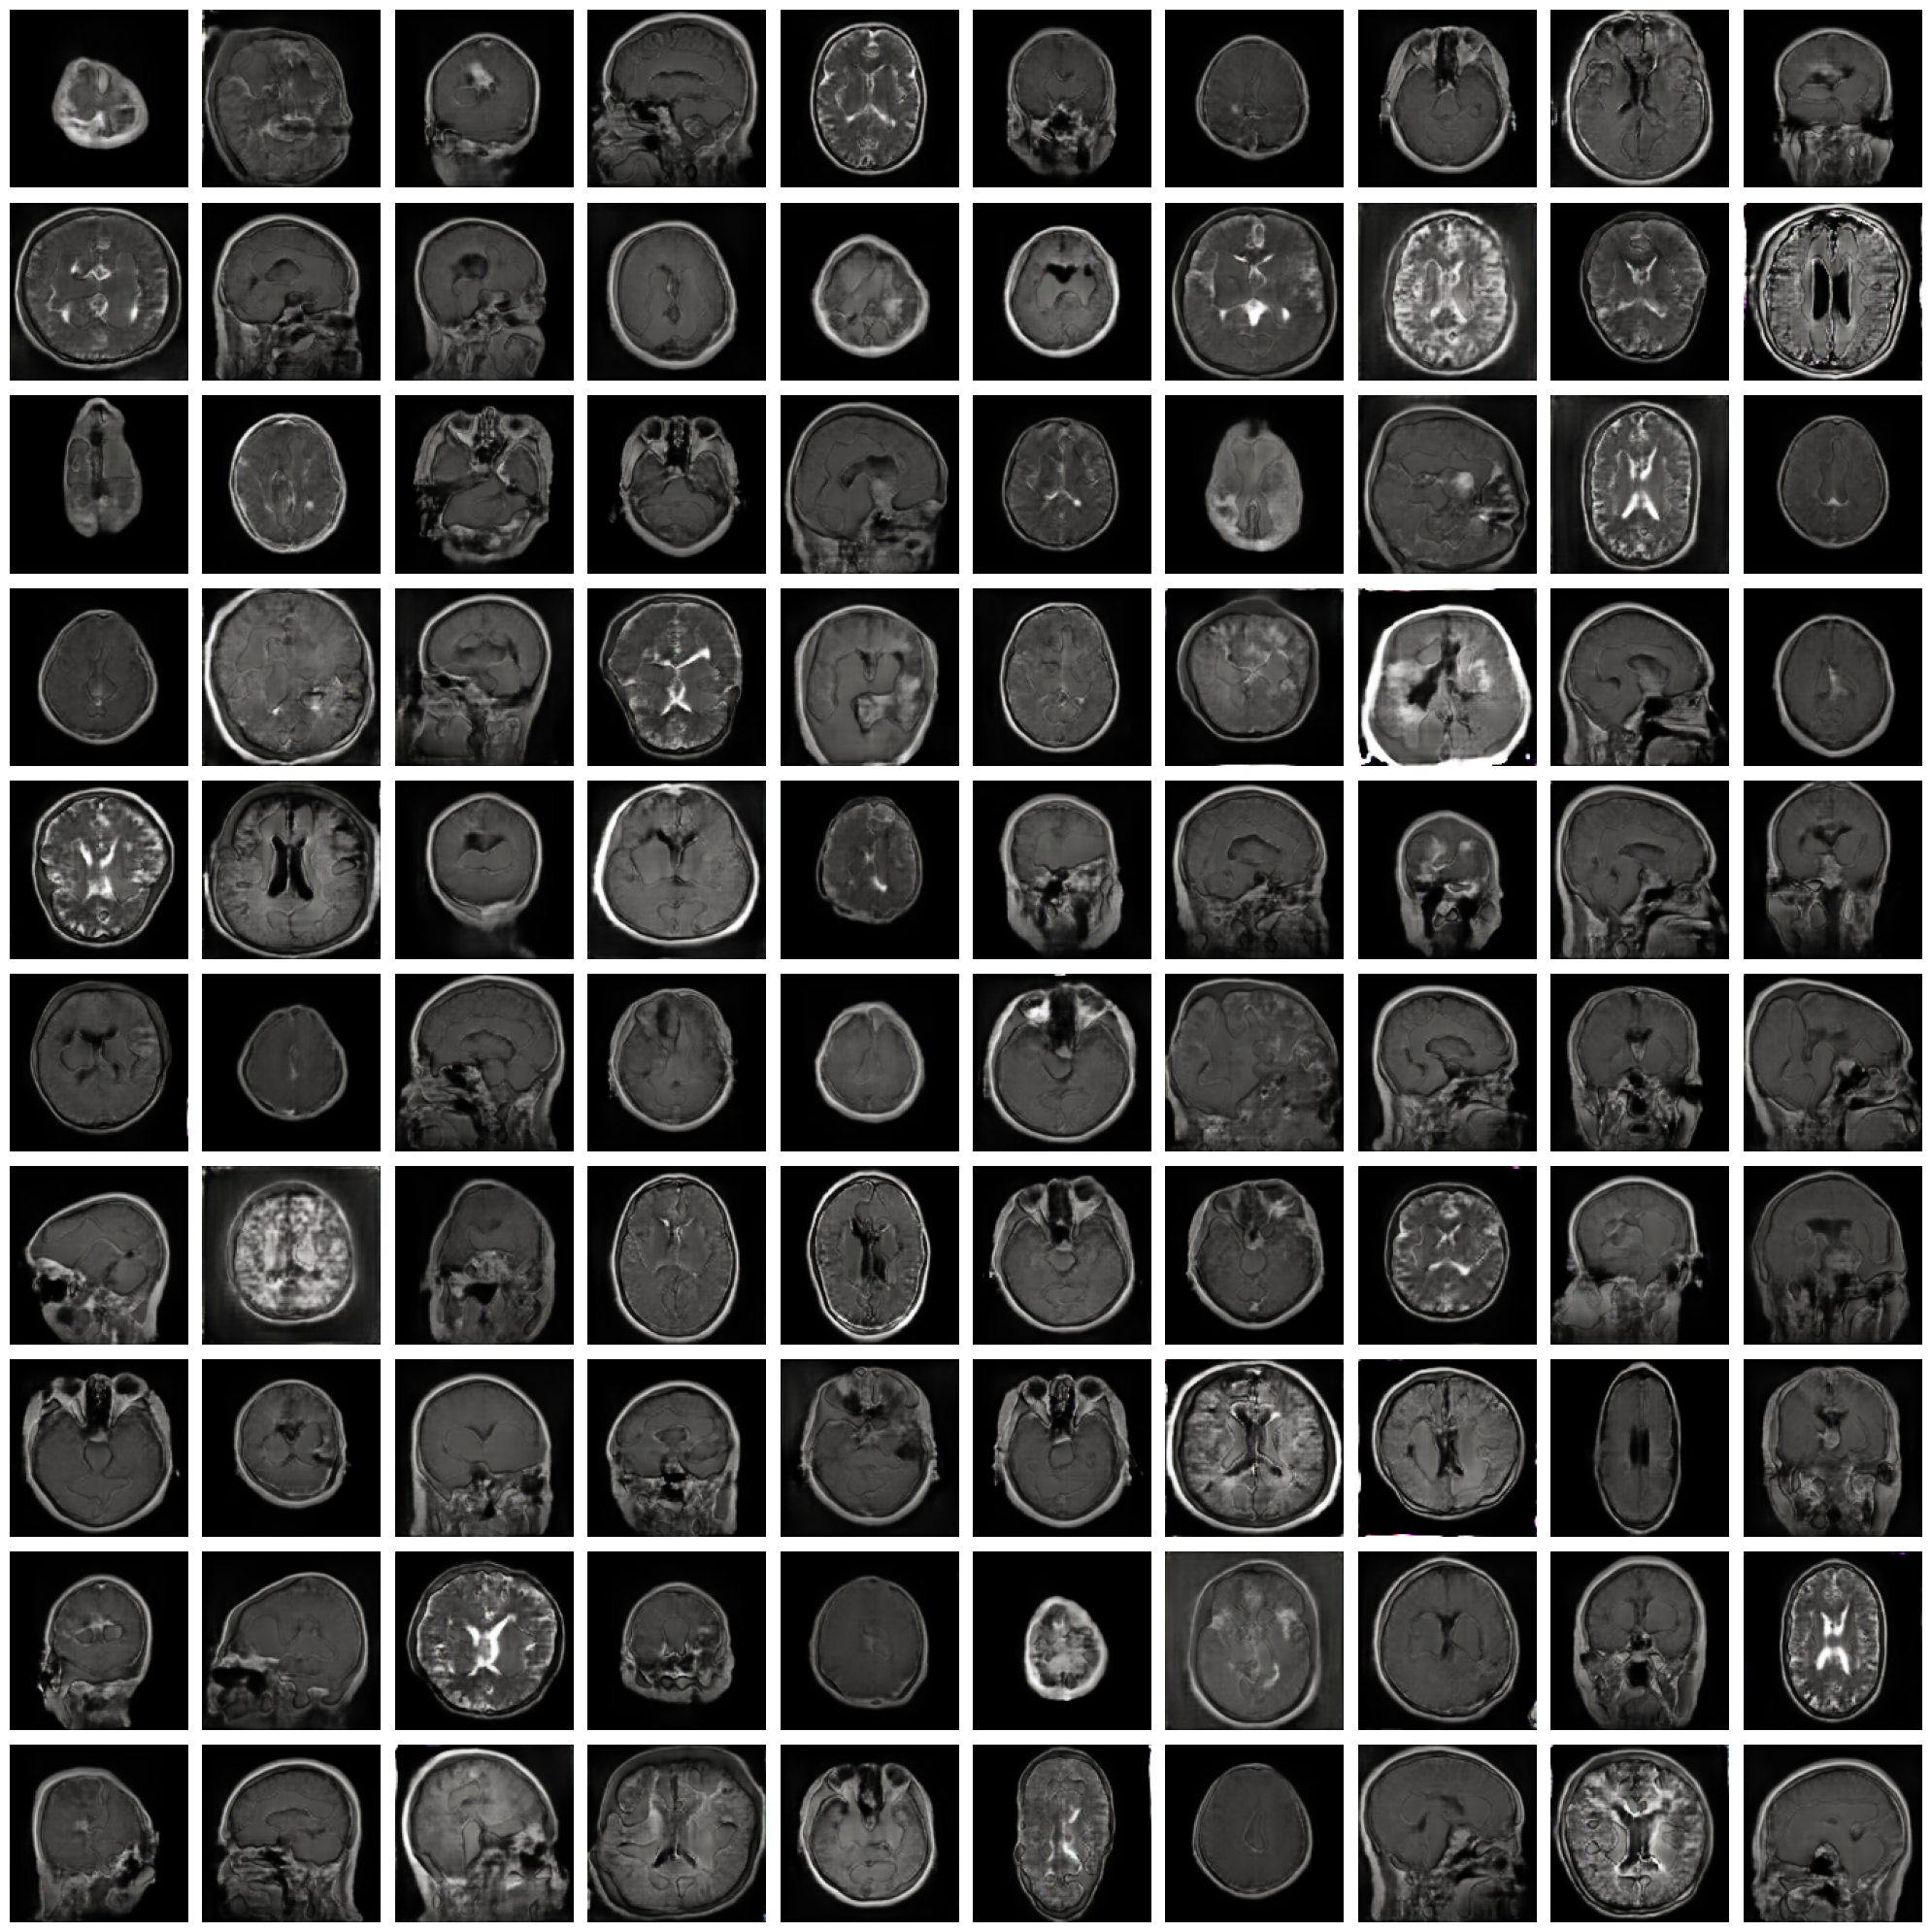

In [26]:
# prompt: visualize generated images from step 5

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Specify the directory containing the generated images
image_dir = "saved_examples/step5"  # Replace with the actual directory


# Get a list of image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Create a figure and axes for the subplots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))  # Adjust the number of rows and columns as needed

# Iterate over the image files and display them in the subplots
for i, image_file in enumerate(image_files[:100]):  # Display up to 100 images
    if i >= 100:
        break
    img = mpimg.imread(os.path.join(image_dir, image_file))
    row = i // 10
    col = i % 10
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [31]:
import pickle

# Save generator
with open('generator.pkl', 'wb') as f:
    pickle.dump(gen.state_dict(), f)

# Save critic
with open('critic.pkl', 'wb') as f:
    pickle.dump(critic.state_dict(), f)

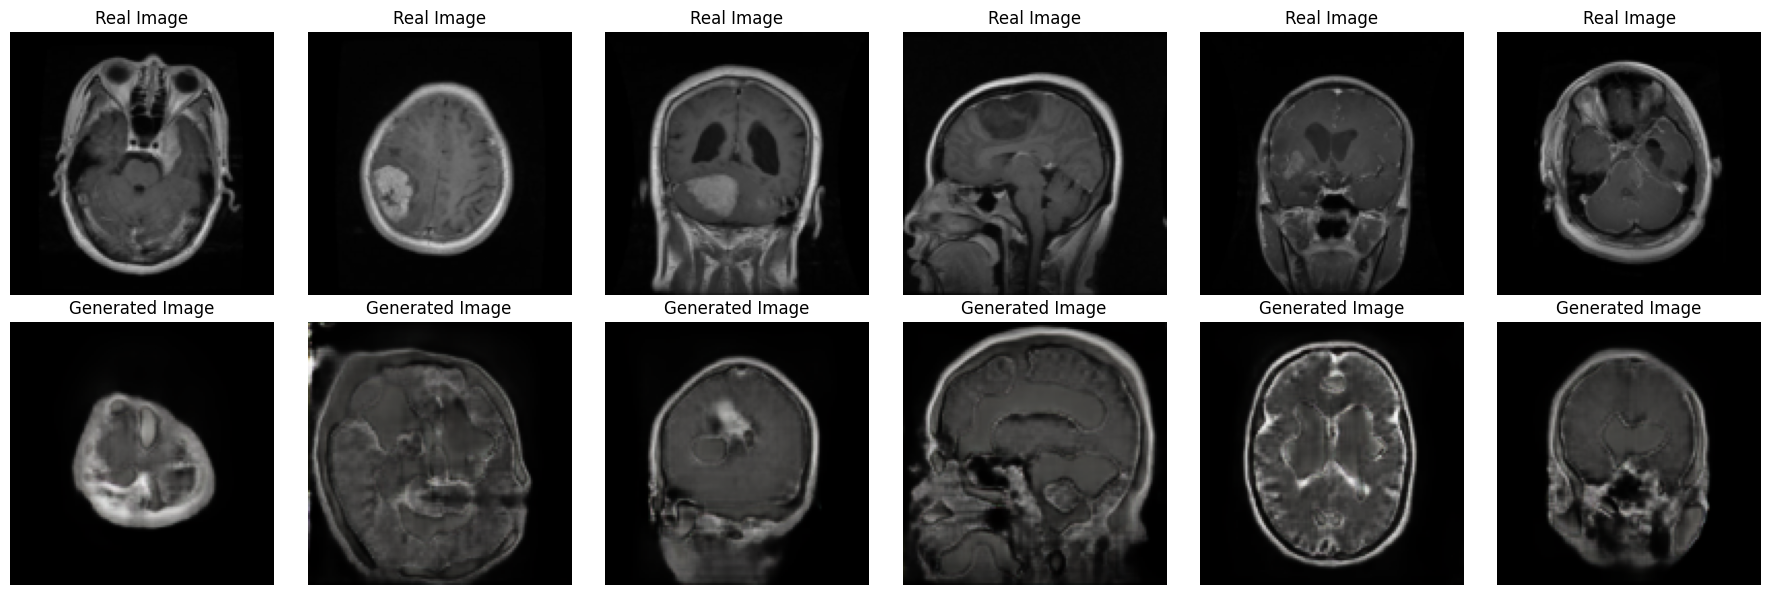

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Directory containing generated images
generated_image_dir = "saved_examples/step5"  # Replace with your actual directory

# Load real examples
real_loader, _ = get_loader(128)  # Assuming 128x128 real images
real_images, _ = next(iter(real_loader))

# Load generated images
generated_image_files = [f for f in os.listdir(generated_image_dir) if os.path.isfile(os.path.join(generated_image_dir, f))]

# Create a figure for side-by-side comparison
fig, axes = plt.subplots(2, 6, figsize=(18, 6))  # 2 rows, 6 columns (left: real, right: generated)

# Display real images on the right
for i in range(6):
    axes[0, i].imshow((real_images[i].permute(1, 2, 0) + 1) / 2)  # Rescale from [-1, 1] to [0, 1]
    axes[0, i].set_title("Real Image")
    axes[0, i].axis("off")

# Display generated images on the left
for i in range(6):
    if i >= len(generated_image_files):  # Handle cases with fewer generated images
        break
    img = mpimg.imread(os.path.join(generated_image_dir, generated_image_files[i]))
    axes[1, i].imshow(img)
    axes[1, i].set_title("Generated Image")
    axes[1, i].axis("off")

# Adjust layout and display the plot
plt.tight_layout()
#plt.suptitle("Real vs Generated Images", fontsize=16, fontweight="bold")
plt.show()


In [61]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0  # Assuming 8-bit images
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=img1.max() - img1.min(), multichannel=True)

def calculate_dice_score(img1, img2):
    img1 = img1 > 0  # Binarize the images
    img2 = img2 > 0
    intersection = np.logical_and(img1, img2)
    dice = 2. * intersection.sum() / (img1.sum() + img2.sum())
    return dice

Real image shape: (128, 128)
Generated image shape: (128, 128)


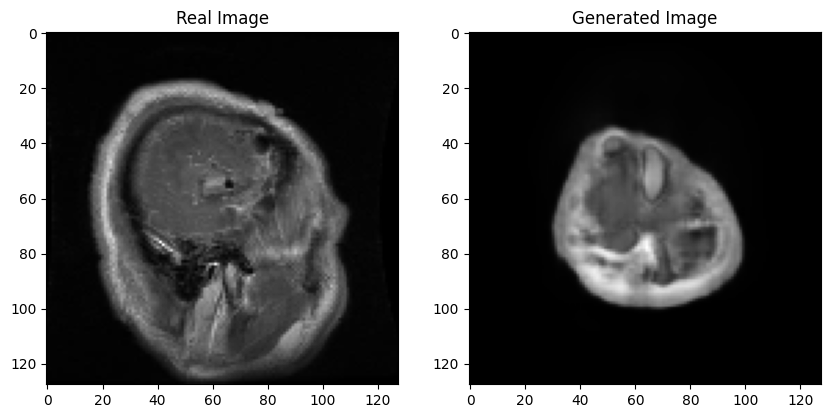

In [79]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np

# Load a real image (replace with your actual file path)
real_image_path = "real_examples/0000.jpg"  # Example path, change to your actual file
real_image = cv2.imread(real_image_path, cv2.IMREAD_GRAYSCALE)

# Load a generated image (replace with your actual file path)
generated_image_path = "ProGan/saved_examples/step5/img_0.png"  # Example path, change to your actual file
generated_image = cv2.imread(generated_image_path, cv2.IMREAD_GRAYSCALE)

# Ensure both images are resized to 128x128
real_image = cv2.resize(real_image, (128, 128))
generated_image = cv2.resize(generated_image, (128, 128))

# Verify the shape of both images
print(f"Real image shape: {real_image.shape}")
print(f"Generated image shape: {generated_image.shape}")

# Example of displaying the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(real_image, cmap='gray')
plt.title("Real Image")

plt.subplot(1, 2, 2)
plt.imshow(generated_image, cmap='gray')
plt.title("Generated Image")

plt.show()


In [80]:

img1 = cv2.imread('Notebooks/saved_examples/step5/img_0.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Notebooks/saved_examples/step5/img_0.png', cv2.IMREAD_GRAYSCALE)
img1 = real_image
img2 = generated_image
    
psnr_value = calculate_psnr(img1, img2)
ssim_value = calculate_ssim(img1, img2)
dice_value = calculate_dice_score(img1, img2)
    
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")
print(f"Dice Score: {dice_value}")

PSNR: 30.26286407959537
SSIM: 0.1575886998665509
Dice Score: 0.6389612645475073
